# Load the data

In [1]:
# Import necessary packages
using DrWatson
using JLD2

# Activate the project environment
@quickactivate :FlowComplexity

# Define the file path
file_path = joinpath("./data", "data.jld2")

# Load the data from the specified file
@load file_path sim_array

1-element Vector{Symbol}:
 :sim_array

# Show time series for all chemostats of simulation no. X

In [2]:
using DataFrames

sim_no = 90
sim = sim_array[sim_no]
nchem = 9

# Define the array that will hold our population time series
max_t = Int(sim.total_time)
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Populate the population array
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
for i in 1:nchem
    for j in 1:max_t
        for k in 1:nspecies
            filtered_time_series_df = filter(row -> row[:reactor] == i && row[:time] == j && row[:variable] == string(k), time_series_df)
            if nrow(filtered_time_series_df) > 0
                pop_array[i, j, k] = filtered_time_series_df[1, :value]
            end
        end
    end
end

using Plots, FileIO

# Create a 3x3 grid plot
plot_grid = plot(layout = (3, 3))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
    end
end


display(plot_grid)

In [21]:
sim_array[90].sim_number
sim_array[90].time_evolution[1][:complete_timeseries]

Dict{Any, Any} with 501 entries:
  56.0  => [5, 26, 1, 2, 3, 1, 3, 2, 1, 1  …  2, 8, 5, 1, 2, 210, 32, 2, 2, 1]
  35.0  => [49, 1, 36, 1, 38, 19, 1, 1, 1, 20  …  3, 2, 3, 1, 1, 1, 3, 6, 3, 3]
  425.0 => [700, 94, 1040, 2, 1, 16, 9, 7, 1, 2  …  3, 575, 1, 1, 106, 1, 94, 2…
  429.0 => [1, 67, 1, 3, 1, 195, 1, 17, 5, 1  …  1, 1, 1, 7, 213, 1, 2, 1, 1, 3]
  60.0  => [7, 4, 1, 1, 18, 36, 1, 3, 1, 5  …  112, 1, 1, 1, 1, 1, 5, 2, 1, 1]
  220.0 => [1, 1, 20, 1, 3, 25, 108, 1, 1, 14  …  2, 1, 1, 1, 3, 1, 28, 1, 1, 8…
  308.0 => [193, 4, 13, 1, 27, 33, 25, 1, 4, 4  …  3, 2, 46, 4, 1, 40, 1, 2, 1,…
  67.0  => [2, 1, 1, 4, 1, 1, 2, 1, 1, 379  …  1, 56, 1, 2, 1, 2, 1, 15, 387, 2…
  215.0 => [1, 1, 13, 46, 1, 190, 10, 49, 1, 17  …  1, 305, 3, 1, 266, 25, 1, 2…
  73.0  => [1, 1, 1, 8, 21, 1, 10, 12, 3, 89  …  1, 1, 1, 41, 6, 1, 15, 109, 89…
  319.0 => [2, 1, 24, 1, 144, 1, 1, 1, 1, 1  …  1, 1, 1, 2, 147, 395, 22, 195, …
  251.0 => [4, 31, 274, 28, 14, 12, 1, 1, 1, 4  …  1, 1, 1, 3, 1, 1, 2, 2, 4, 1]


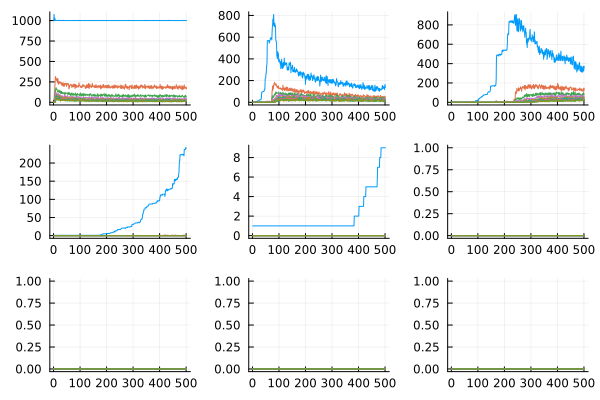

In [2]:
using DataFrames, Plots, FileIO

sim_no = 50
sim = sim_array[sim_no]
nchem = 9

# Define the array that will hold our population time series
max_t = Int(sim.total_time) + 1 # our sim goes to 0...100 so index has to go 1...101
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Convert the time series to a DataFrame
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)

# Populate the population array using efficient DataFrame operations
for row in eachrow(time_series_df)
    
    i = Int(row[:reactor])
    j = round(Int, row[:time]) + 1 # indexing starts at 1
    k = parse(Int, row[:variable]) # to account for absent data (i.e., zero)
    if k > nspecies
        continue
    end
    # println(row)
    # println("i=$i j=$j k=$k")
    pop_array[i, j, k] = row[:value]
end

# Create a 3x3 grid plot
plot_grid = plot(layout = (3, 3))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
    end
end

display(plot_grid)

# Plot the Std(M) vs $k_d$ 

## (i.e., the std of monomers vs the outflow)

In [3]:
using DataFrames, Plots, FileIO, Statistics

first_sim = sim_array[1]
nsims = 100
nchem = 9
nspecies = 10
t = 500

# Define the array that will hold our data
pops = zeros(Float64, nsims, nchem, nspecies)

# Loop over all the simulations
for i in 1:100
    try
        sim = sim_array[i]
        df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
        df = filter(row -> row[:time] == t, df)

        for j in 1:nchem
            df_reactor = filter(row -> row[:reactor] == j, df)

            for k in 1:nspecies
                df_reactor_species = filter(row -> row[:variable] == string(k), df_reactor)
                if nrow(df_reactor_species) > 0
                    pops[i, j, k] = df_reactor_species[1, :value]      
                end
            end
        end
    catch
        continue
    end
end

In [ ]:
display(pops[2,:,:])

In [4]:
stds = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        stds[i, j] = std(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(stds)

100×10 Matrix{Float64}:
 333.333  65.0     23.6667  15.3333   10.0      …   4.0      3.33333  2.0
 333.089  65.3333  24.3333   9.0      10.0          4.66667  3.33333  6.0
 334.0    62.0     25.3333  14.6667   10.0          4.66667  4.33333  3.0
 333.333  61.3333  19.3333  12.0      11.0          4.33333  3.66667  4.33333
 333.333  61.3333  25.0     14.3333   12.3333       4.66667  1.66667  2.31541
 333.333  54.0     31.0     15.0       8.66667  …   5.33333  5.33333  4.0
 333.21   65.0     25.6667  14.0       9.0          3.33333  7.33333  3.0
 346.091  79.223   32.1939  20.7391   17.636        7.33333  6.51494  4.0
 333.011  63.0     25.6667  16.0      12.0          5.66667  5.33333  4.0
 333.625  65.3333  21.0      8.66667  10.0          4.0      4.0      2.33333
   ⋮                                            ⋱                     
 286.083  56.7563  22.6495  15.6605    9.12414      6.72888  6.42262  6.22718
 281.05   57.6378  25.759   16.5109   16.084        6.42262  6.86982  3.968

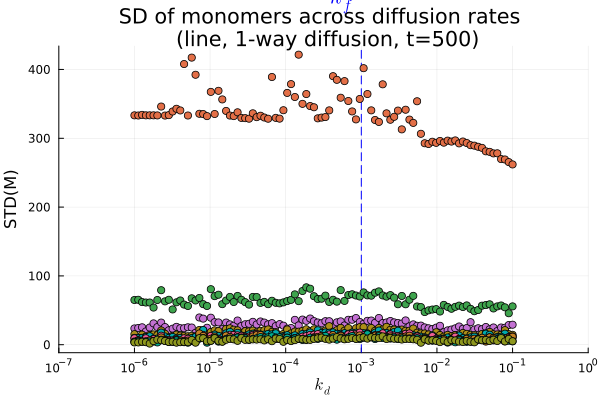

In [13]:
using LaTeXStrings

# p = plot()
s = scatter(title="SD of monomers across diffusion rates \n (line, 1-way diffusion, t=500)", xlim=(1e-7, 1e-0))

n = 100
vals = exp10.(LinRange(-6,-1,n))

# kf = 0.001
vline!([0.001], label="vline", linestyle=:dash, color=:blue)
annotate!(0.0004, 500, text(L"k_f", :left, 15, color=:blue))

for i in 1:9
    # plot!(p, vals, stds[:, i], xscale=:log10, xlabel="kd", ylabel="STD(M)", legend= :none)
    scatter!(s, vals, stds[:, i], xscale=:log10, xlabel=L"k_d", ylabel="STD(M)", legend= :none)
end

# display(p)
display(s)

In [ ]:
display(stds)

In [ ]:
std([1000,10,20,50,1,0,0,0,0])

In [41]:
mu = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        mu[i, j] = mean(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(mu)

100×10 Matrix{Float64}:
 111.111   22.5556  11.3333    7.44444  …   2.22222   1.77778   2.66667
 111.111   23.3333  10.1111    7.33333      3.33333   2.22222   1.88889
 111.111   23.6667  10.4444    5.88889      4.33333   2.55556   2.66667
 111.111   22.0      8.44444   6.55556      3.0       2.33333   2.44444
 111.111   21.8889   8.55556   7.33333      3.77778   2.55556   1.44444
 111.111   22.5556   9.66667   6.77778  …   2.55556   2.22222   2.55556
 111.222   23.2222  10.7778    4.44444      3.0       2.33333   2.33333
 111.222   21.6667  11.0       6.0          3.11111   1.77778   1.66667
 111.222   21.4444   8.55556   6.22222      2.55556   1.77778   1.55556
 111.222   22.8889  10.8889    6.11111      1.88889   2.55556   2.33333
   ⋮                                    ⋱                      
 438.667  106.222   62.3333   44.3333      22.3333   18.2222   12.7778
 373.0    105.778   66.7778   47.8889      20.0      18.5556   17.3333
 357.667  103.333   71.8889   47.3333      26.6667

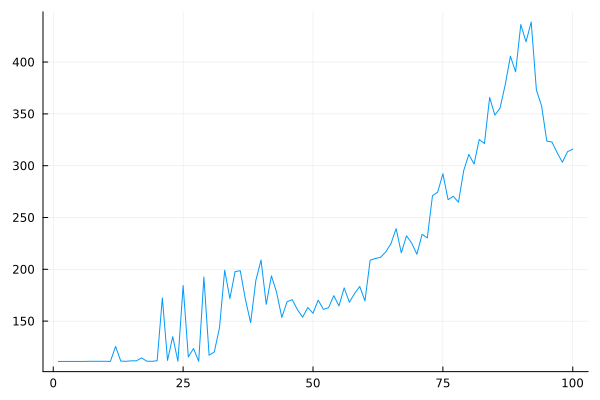

In [42]:
p = plot()

for i in 1:1
    plot!(p, 1:100, mu[:, i], legend= :none)
end

display(p)